# **1. LSTM/GRU (No Attention)**

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.5014 - loss: 5.5453 - val_accuracy: 0.5151 - val_loss: 3.5915
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5753 - loss: 2.9425 - val_accuracy: 0.5433 - val_loss: 3.5283
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.5832 - loss: 2.8154 - val_accuracy: 0.5466 - val_loss: 3.5068
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5909 - loss: 2.7008 - val_accuracy: 0.5487 - val_loss: 3.5016
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.5984 - loss: 2.6237 - val_accuracy: 0.5511 - val_loss: 3.5040
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.6092 - loss: 2.5274 - val_accuracy: 0.5522 - val_loss: 3.5002
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.6074 - loss: 2.5061 - val_accuracy: 0.5571 - val_loss: 3.5046
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.6205 - loss: 2.3883 

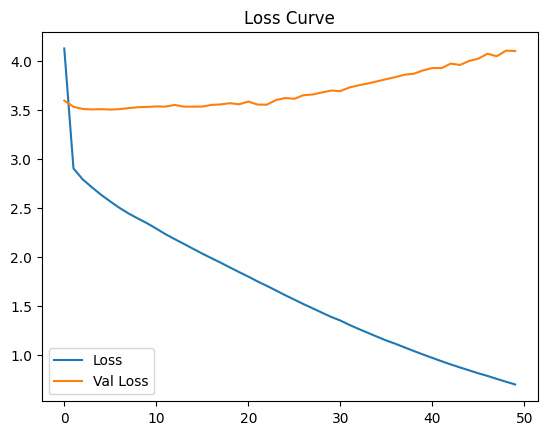

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

data = pd.read_csv('Grammar Correction.csv')
input_texts = data['Ungrammatical Statement'].astype(str).tolist()
target_texts = ['<start> ' + t + ' <end>' for t in data['Standard English'].astype(str).tolist()]

# Tokenization
input_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

input_sequences = input_tokenizer.texts_to_sequences(input_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

max_encoder_len = max([len(seq) for seq in input_sequences])
max_decoder_len = max([len(seq) for seq in target_sequences])

encoder_input = pad_sequences(input_sequences, maxlen=max_encoder_len, padding='post')
decoder_input = pad_sequences([seq[:-1] for seq in target_sequences], maxlen=max_decoder_len - 1, padding='post')
decoder_output = pad_sequences([seq[1:] for seq in target_sequences], maxlen=max_decoder_len - 1, padding='post')

# Vocabulary sizes
encoder_vocab = len(input_tokenizer.word_index) + 1
decoder_vocab = len(target_tokenizer.word_index) + 1

# Build the model
embed_dim = 64
latent_dim = 128

encoder_inputs = tf.keras.Input(shape=(None,))
enc_emb = tf.keras.layers.Embedding(encoder_vocab, embed_dim)(encoder_inputs)
_, state_h, state_c = tf.keras.layers.LSTM(latent_dim, return_state=True)(enc_emb)

decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb = tf.keras.layers.Embedding(decoder_vocab, embed_dim)(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
decoder_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = tf.keras.layers.Dense(decoder_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([encoder_input, decoder_input],
                    np.expand_dims(decoder_output, -1),
                    batch_size=16,
                    epochs=50,
                    validation_split=0.2)


plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()


In [ ]:
!pip install tensorflow matplotlib seaborn


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



In [ ]:

df = pd.read_csv("/content/Grammar Correction.csv")

df = df[['Ungrammatical Statement', 'Standard English']].dropna()
df.columns = ['input_text', 'target_text']


print(df.sample(5))


                                            input_text  \
66    The students was taking a test in the classroom.   
604                           Theyre dog is very cute.   
1853      The girl found the lost puppy was very kind.   
1237   The reason for the delay is due to the weather.   
1016           I like to exercise, or I like to relax.   

                                            target_text  
66    The students were taking a test in the classroom.  
604                             Their dog is very cute.  
1853   The girl who found the lost puppy was very kind.  
1237                   The delay is due to the weather.  
1016                I like to either exercise or relax.  


In [ ]:

def preprocess(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    return text

df['input_text'] = df['input_text'].apply(preprocess)
df['target_text'] = df['target_text'].apply(lambda x: '<start> ' + preprocess(x) + ' <end>')

In [ ]:

train_input, val_input, train_target, val_target = train_test_split(df['input_text'], df['target_text'], test_size=0.1, random_state=42)

In [ ]:

SRC_VOCAB = 10000
TGT_VOCAB = 10000


src_tok = tf.keras.preprocessing.text.Tokenizer(num_words=SRC_VOCAB, oov_token="<unk>")
src_tok.fit_on_texts(train_input)
train_input_seq = src_tok.texts_to_sequences(train_input)
val_input_seq = src_tok.texts_to_sequences(val_input)


tgt_tok = tf.keras.preprocessing.text.Tokenizer(num_words=TGT_VOCAB, oov_token="<unk>", filters='')
tgt_tok.fit_on_texts(train_target)
train_target_seq = tgt_tok.texts_to_sequences(train_target)
val_target_seq = tgt_tok.texts_to_sequences(val_target)


train_input_seq = tf.keras.preprocessing.sequence.pad_sequences(train_input_seq, padding='post')
val_input_seq = tf.keras.preprocessing.sequence.pad_sequences(val_input_seq, padding='post')
train_target_seq = tf.keras.preprocessing.sequence.pad_sequences(train_target_seq, padding='post')
val_target_seq = tf.keras.preprocessing.sequence.pad_sequences(val_target_seq, padding='post')

print(f"Train size: {len(train_input_seq)}, Validation size: {len(val_input_seq)}")

Train size: 1816, Validation size: 202


In [ ]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000


train_dataset = tf.data.Dataset.from_tensor_slices((train_input_seq, train_target_seq)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input_seq, val_target_seq)).batch(BATCH_SIZE, drop_remainder=True)


SRC_VOCAB_SIZE = len(src_tok.word_index) + 1
TGT_VOCAB_SIZE = len(tgt_tok.word_index) + 1

SRC_MAX_LEN = train_input_seq.shape[1]
TGT_MAX_LEN = train_target_seq.shape[1]

print("SRC_VOCAB_SIZE:", SRC_VOCAB_SIZE)
print("TGT_VOCAB_SIZE:", TGT_VOCAB_SIZE)
print("SRC_MAX_LEN:", SRC_MAX_LEN)
print("TGT_MAX_LEN:", TGT_MAX_LEN)

SRC_VOCAB_SIZE: 3034
TGT_VOCAB_SIZE: 3672
SRC_MAX_LEN: 22
TGT_MAX_LEN: 22


In [ ]:

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, h, c = self.lstm(x, initial_state=hidden)
        return output, h, c

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units))]

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, enc_output):
        x = self.embedding(x)
        output, h, c = self.lstm(x, initial_state=hidden)
        output = self.fc(output)
        return output, h, c

In [ ]:

embedding_dim = 256
units = 512
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, enc_hidden)

        dec_hidden = [enc_hidden_h, enc_hidden_c]
        dec_input = tf.expand_dims([tgt_tok.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden_h, dec_hidden_c = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions[:, 0, :])
            dec_input = tf.expand_dims(targ[:, t], 1)
            dec_hidden = [dec_hidden_h, dec_hidden_c]

    batch_loss = loss / int(targ.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [ ]:

EPOCHS = 10
loss_plot = []

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    loss_plot.append(total_loss / len(train_dataset))
    print(f'Epoch {epoch + 1} Loss {total_loss / len(train_dataset):.4f}, Time {time.time() - start:.2f} sec')


Epoch 1 Loss 3.2047, Time 328.78 sec
Epoch 2 Loss 2.6222, Time 281.35 sec
Epoch 3 Loss 2.4754, Time 292.61 sec
Epoch 4 Loss 2.3609, Time 280.24 sec
Epoch 5 Loss 2.2627, Time 292.82 sec
Epoch 6 Loss 2.1621, Time 280.52 sec
Epoch 7 Loss 2.0759, Time 291.10 sec
Epoch 8 Loss 1.9949, Time 282.57 sec
Epoch 9 Loss 1.9218, Time 293.97 sec
Epoch 10 Loss 1.8458, Time 281.42 sec


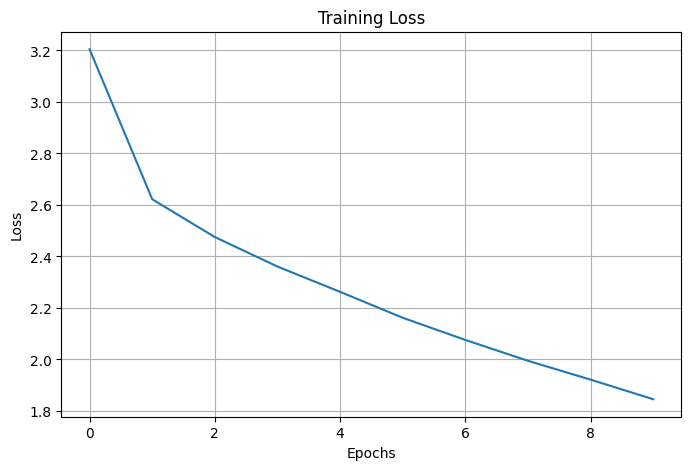

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(loss_plot)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:

encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")




In [ ]:

def evaluate(sentence):
    sentence = preprocess(sentence)
    inputs = [src_tok.word_index.get(w, src_tok.word_index["<unk>"]) for w in sentence.split()]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=SRC_MAX_LEN, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    enc_hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs, enc_hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]

    dec_input = tf.expand_dims([tgt_tok.word_index['<start>']], 0)

    for t in range(TGT_MAX_LEN):
        predictions, dec_hidden_h, dec_hidden_c = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0][0]).numpy()
        next_word = tgt_tok.index_word.get(predicted_id, '')

        if next_word == '<end>':
            break

        result += next_word + ' '

        dec_input = tf.expand_dims([predicted_id], 0)
        dec_hidden = [dec_hidden_h, dec_hidden_c]

    return result.strip()

In [ ]:

print("Input:", val_input.iloc[0])
print("Target:", val_target.iloc[0])
print("Prediction:", evaluate(val_input.iloc[0]))


Input: he didn t eat no breakfast this morning.
Target: <start>  sos he didn t eat any breakfast this morning. eos  <end>
Prediction: sos the movie was very than the table. eos


In [ ]:
# BLEU and ROUGE Evaluation
predictions = []
references = []

for i in range(len(val_input)):
    pred = evaluate(val_input.iloc[i])
    predictions.append(pred)
    references.append(val_target.iloc[i].split())

NameError: name 'val_input' is not defined

In [ ]:
def evaluate_bleu(references, predictions):
    smoothie = SmoothingFunction().method4
    scores = []
    for ref, pred in zip(references, predictions):
        ref_tokens = [ref] if isinstance(ref[0], str) else ref  # Ensure nested list for BLEU
        pred_tokens = pred.split()
        score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
        scores.append(score)
    return sum(scores) / len(scores)


In [ ]:
# Calculate BLEU score
bleu_score = evaluate_bleu(references, predictions)
print("BLEU score:", bleu_score)

# Compute ROUGE score
from rouge_score import rouge_scorer
import numpy as np

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
for ref, pred in zip(references, predictions):
    score = scorer.score(' '.join(ref), pred)
    rouge_scores.append(score)

# Print average ROUGE scores
rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

print(f"ROUGE-1: {rouge1:.4f}, ROUGE-2: {rouge2:.4f}, ROUGE-L: {rougeL:.4f}")


BLEU score: 0.03993087695473212
ROUGE-1: 0.2959, ROUGE-2: 0.0533, ROUGE-L: 0.2920


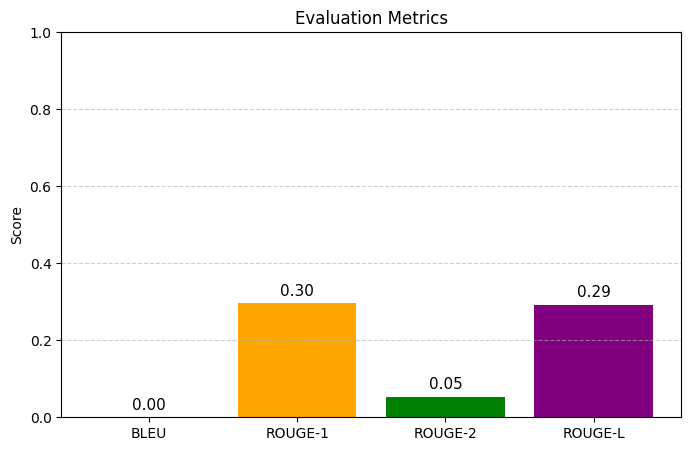

In [ ]:
# Assuming these are already computed
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [bleu_score, rouge1, rouge2, rougeL]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add score labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=11)

plt.show()


# **2. With Attention (Bahdanau/Luong)**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Target Tokenizer Word Index: {'<unk>': 1, 'the': 2, 'start': 3, 'end': 4, 'to': 5, 'is': 6, 'a': 7, 'and': 8, 'was': 9, 'in': 10, 'i': 11, 'she': 12, 'of': 13, 'he': 14, 'for': 15, 'on': 16, 'at': 17, 'are': 18, 'were': 19, 'new': 20, 'this': 21, 'her': 22, 'by': 23, 'with': 24, 'you': 25, 'have': 26, 'than': 27, 'has': 28, 'it': 29, 'his': 30, 'their': 31, 'they': 32, 'but': 33, 'my': 34, 'its': 35, 'be': 36, 'that': 37, 'if': 38, 'store': 39, 'book': 40, 'very': 41, 'we': 42, 'more': 43, 'car': 44, 'work': 45, 'will': 46, 'not': 47, 'students': 48, 'movie': 49, 'any': 50, 'an': 51, 'had': 52, 'cake': 53, 'went': 54, 'need': 55, 'project': 56, 'about': 57, 'meeting': 58, 'team': 59, 'so': 60, 'last': 61, 'dog': 62, 'going': 63, 'park': 64, 'beautiful': 65, 'been': 66, 'would': 67, 'needs': 68, 'can': 69, 'delicious': 70, "he's": 71, 'party': 72, 'concert': 73, 'day': 74, 'play': 75, 'every': 76, 'me': 77, 'as': 78, 'one': 79, 'company': 80, "it's": 81, 'your': 82, "can't": 83, 'time':

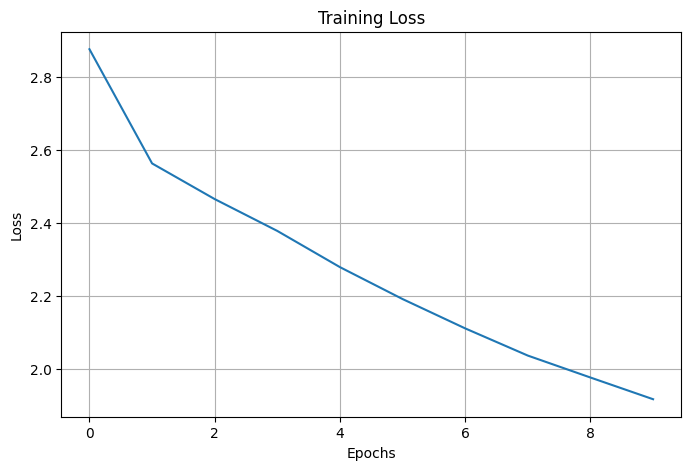

In [ ]:
# Install required libraries
!pip install tensorflow matplotlib seaborn nltk rouge-score

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('punkt')
nltk.download('wordnet')

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------

df = pd.read_csv("/content/Grammar Correction.csv")
df = df[['Ungrammatical Statement', 'Standard English']].dropna()
df.columns = ['input_text', 'target_text']

def clean_text(text):
    text = text.lower().strip()
    return text

df['input_text'] = df['input_text'].apply(clean_text)
df['target_text'] = df['target_text'].apply(clean_text)



# Add <start> and <end> tokens for the decoder target sequences
df['target_text'] = '<start> ' + df['target_text'] + ' <end>'

# Tokenizers for input and target
input_tokenizer = Tokenizer(oov_token="<unk>")
target_tokenizer = Tokenizer(oov_token="<unk>")

# Fit tokenizers on the text data
input_tokenizer.fit_on_texts(df['input_text'])
target_tokenizer.fit_on_texts(df['target_text'])

# Ensure that '<start>' is added to the target tokenizer's word index
if '<start>' not in target_tokenizer.word_index:
    target_tokenizer.word_index['<start>'] = len(target_tokenizer.word_index) + 1

# Check and print the word index for target_tokenizer to debug
print("Target Tokenizer Word Index:", target_tokenizer.word_index)

input_seq = input_tokenizer.texts_to_sequences(df['input_text'])
target_seq = target_tokenizer.texts_to_sequences(df['target_text'])

max_len = max(max(len(seq) for seq in input_seq), max(len(seq) for seq in target_seq))
input_seq = pad_sequences(input_seq, padding='post', maxlen=max_len)
target_seq = pad_sequences(target_seq, padding='post', maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(input_seq, target_seq, test_size=0.2, random_state=42)

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# ---------------------------
# Attention Layer
# ---------------------------

class Attention(tf.keras.layers.Layer):
    def __init__(self, units=128):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))  # (batch_size, max_seq_len, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, max_seq_len, 1)
        context_vector = attention_weights * values  # (batch_size, max_seq_len, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        return context_vector, attention_weights

# ---------------------------
# Encoder Model
# ---------------------------

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, h, c = self.lstm(x, initial_state=hidden)
        return output, h, c

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units))]

# ---------------------------
# Decoder Model
# ---------------------------

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden[0], enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, h, c = self.lstm(x, initial_state=hidden)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, h, c, attention_weights

# ---------------------------
# Hyperparameters & optimizer
# ---------------------------

embedding_dim = 256
units = 512
BATCH_SIZE = 64

encoder = Encoder(input_vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # ignore padding (0)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# ---------------------------
# Training step function
# ---------------------------

@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, enc_hidden)
        dec_hidden = [enc_hidden_h, enc_hidden_c]
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
            dec_hidden = [dec_hidden_h, dec_hidden_c]

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

# ---------------------------
# Dataset preparation
# ---------------------------

BUFFER_SIZE = len(X_train)
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# ---------------------------
# Training loop
# ---------------------------

EPOCHS = 10
loss_plot = []

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    loss_plot.append(total_loss / steps_per_epoch)
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}, Time {time.time() - start:.2f} sec')

# ---------------------------
# Plot training loss
# ---------------------------

plt.figure(figsize=(8,5))
plt.plot(loss_plot)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

# ---------------------------
# Save models (optional)
# ---------------------------

encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")



In [ ]:
!pip install rouge-score  # Install the missing module

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=86d0f9f690a8db1b8be226bcddac7df0474a768729bc495d126ea5ec6f4a1b3c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
def evaluate_sentence(sentence):
    sentence = clean_text(sentence)
    inputs = [input_tokenizer.word_index.get(word, input_tokenizer.word_index["<unk>"]) for word in sentence.split()]
    inputs = pad_sequences([inputs], maxlen=max_len, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    enc_hidden = [tf.zeros((1, units)), tf.zeros((1, units))]
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs, enc_hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(max_len):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()

        if target_tokenizer.index_word.get(predicted_id) == '<end>':
            break

        result += target_tokenizer.index_word.get(predicted_id, '') + ' '
        dec_input = tf.expand_dims([predicted_id], 0)
        dec_hidden = [dec_hidden_h, dec_hidden_c]

    return result.strip()


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.metrics.distance import edit_distance
import pandas as pd # Import pandas to use DataFrames

smoothie = SmoothingFunction().method4
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

bleu_scores = []
rouge1_scores = []
rougeL_scores = []
edit_distances = []
exact_matches = []

num_samples = 200  # You can increase for better statistics

for i in range(num_samples):
    input_sentence = df['input_text'].iloc[i]
    target_sentence = df['target_text'].iloc[i].replace('<start>', '').replace('<end>', '').strip()
    predicted_sentence = evaluate_sentence(input_sentence)

    ref = [target_sentence.split()]
    hyp = predicted_sentence.split()

    bleu = sentence_bleu(ref, hyp, smoothing_function=smoothie)
    r_scores = rouge.score(target_sentence, predicted_sentence)

    bleu_scores.append(bleu)
    rouge1_scores.append(r_scores['rouge1'].fmeasure)
    rougeL_scores.append(r_scores['rougeL'].fmeasure)
    edit_distances.append(edit_distance(target_sentence, predicted_sentence))
    exact_matches.append(1 if target_sentence == predicted_sentence else 0)


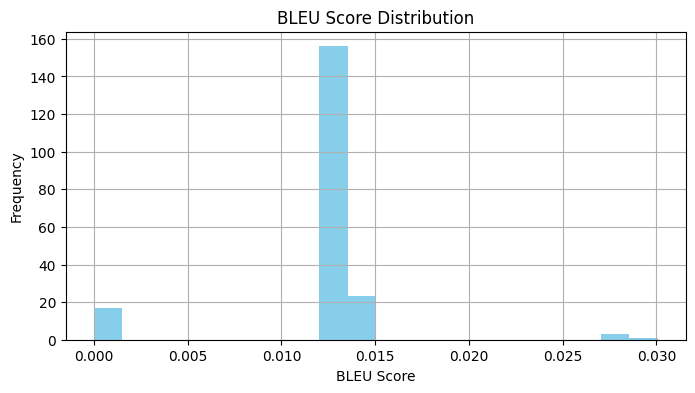

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(bleu_scores, bins=20, color='skyblue')
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()


# **3. Transformer (Self-Attention)**

In [ ]:
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


DataFrame shape: (2018, 4)
DataFrame columns: ['Serial Number', 'Error Type', 'Ungrammatical Statement', 'Standard English']
Before padding lengths:
 Train SRC sequences: 1614
 Test SRC sequences: 404
After padding shapes:
 Train SRC shape: (1614, 22)
 Test SRC shape: (404, 22)
 Train TGT shape: (1614, 18)
 Test TGT shape: (404, 18)


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 128)   │    640,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 22, 128)   │          0 │ embedding[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 128)   │     66,048 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 128)   │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 22, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 22, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 22, 128)   │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 22, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 22, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 22, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 17, 128)   │    640,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 22, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 17, 128)   │          0 │ embedding_1[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 22, 256)   │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 17, 128)   │     66,048 │ positional_encod

 Total params: 2,587,528 (9.87 MB)

 Trainable params: 2,587,528 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - loss: 5.3513 - val_loss: 3.1893
Epoch 2/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - loss: 3.0743 - val_loss: 3.0510
Epoch 3/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 2.8439 - val_loss: 2.9309
Epoch 4/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - loss: 2.6260 - val_loss: 2.8555
Epoch 5/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 2.4025 - val_loss: 2.8386
Epoch 6/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 2.2068 - val_loss: 2.8151
Epoch 7/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - loss: 2.0442 - val_loss: 2.8175
Epoch 8/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - loss: 1.8537 - val_loss: 2.8128
Epoch 9/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 1.6344 - val_loss: 2.8337
Epoch 10/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 1.4543 - val_loss: 2.9174
Epoch 11/15
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 1.2852 - val_loss: 2.9760
Epoch 12/15
101/101

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



=== Evaluation Results ===
BLEU Score     : 0.4910
ROUGE-L F1     : 0.2660
Training Time  : 324.85 seconds
Infer Speed    : 0.1338 sec/sample


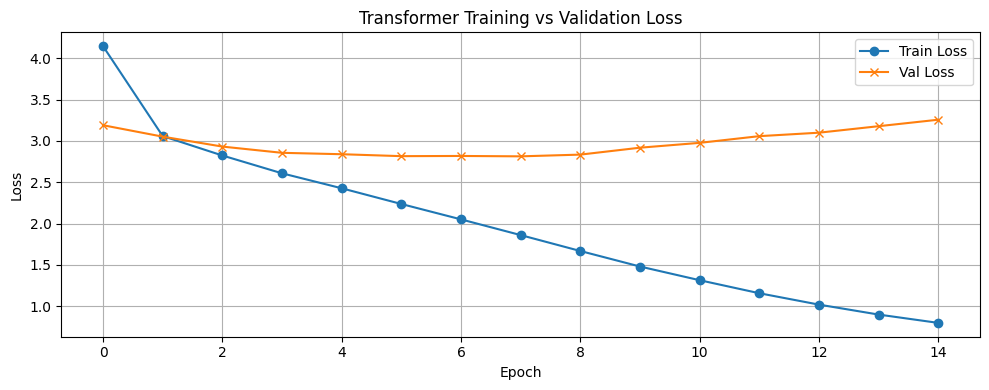

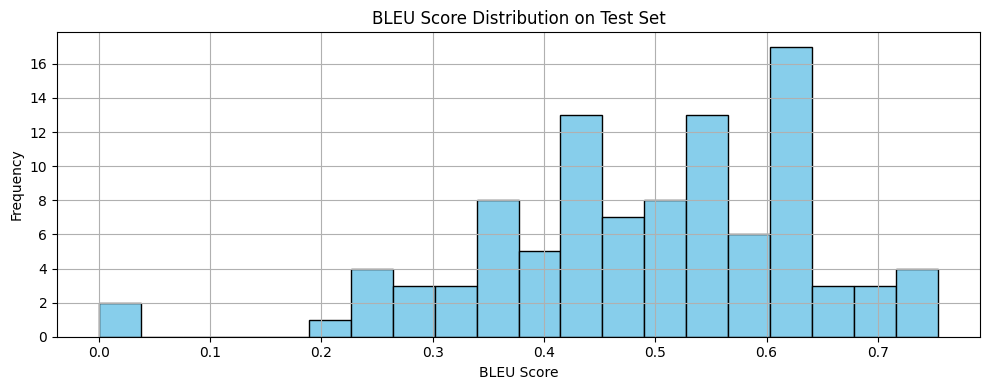

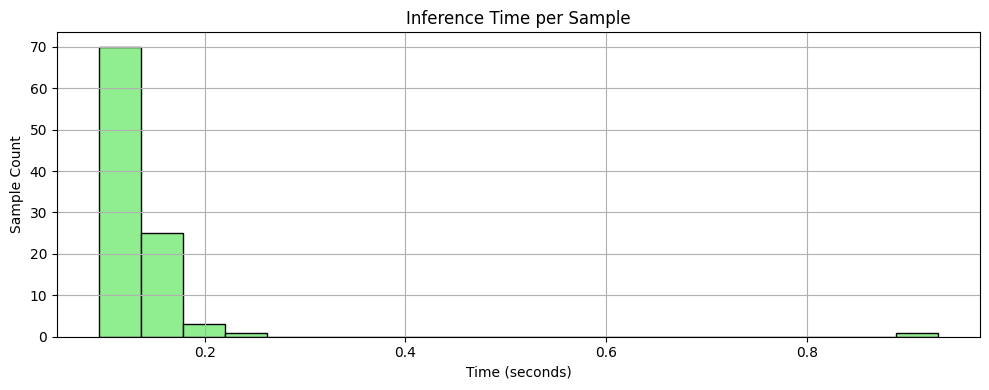

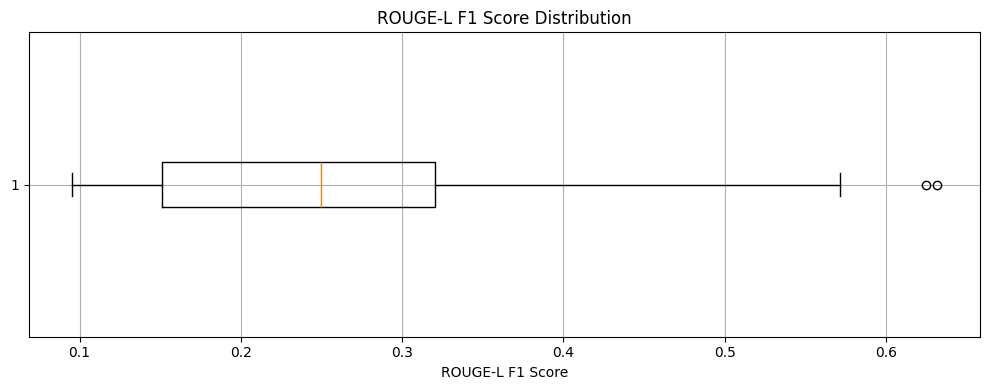

In [ ]:
# Install required packages
!pip install tensorflow matplotlib seaborn nltk rouge-score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import time
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Clear any previous TF sessions
tf.keras.backend.clear_session()

data_path = '/content/Grammar Correction.csv'
df = pd.read_csv(data_path)

print("DataFrame shape:", df.shape)
print("DataFrame columns:", df.columns.tolist())

required_cols = ['Ungrammatical Statement', 'Standard English']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataset columns: {df.columns.tolist()}")

# Extract columns
input_texts = df['Ungrammatical Statement'].values
target_texts = df['Standard English'].values

# ----------- TOKENIZATION & PREPROCESSING ------------

src_tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tgt_tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")

src_tokenizer.fit_on_texts(input_texts)
tgt_tokenizer.fit_on_texts(target_texts)

# Train-test split
train_input_texts, test_input_texts, train_target_texts, test_target_texts = train_test_split(
    input_texts, target_texts, test_size=0.2, random_state=42
)

train_src_seq = src_tokenizer.texts_to_sequences(train_input_texts)
train_tgt_seq = tgt_tokenizer.texts_to_sequences(train_target_texts)
test_src_seq = src_tokenizer.texts_to_sequences(test_input_texts)
test_tgt_seq = tgt_tokenizer.texts_to_sequences(test_target_texts)

print("Before padding lengths:")
print(f" Train SRC sequences: {len(train_src_seq)}")
print(f" Test SRC sequences: {len(test_src_seq)}")

SRC_LEN = max(max(len(seq) for seq in train_src_seq), max(len(seq) for seq in test_src_seq))
TGT_LEN = max(max(len(seq) for seq in train_tgt_seq), max(len(seq) for seq in test_tgt_seq))
DEC_LEN = TGT_LEN - 1

# Pad sequences
train_src_seq = pad_sequences(train_src_seq, maxlen=SRC_LEN, padding='post')
test_src_seq = pad_sequences(test_src_seq, maxlen=SRC_LEN, padding='post')
train_tgt_seq = pad_sequences(train_tgt_seq, maxlen=TGT_LEN, padding='post')
test_tgt_seq = pad_sequences(test_tgt_seq, maxlen=TGT_LEN, padding='post')

print("After padding shapes:")
print(f" Train SRC shape: {train_src_seq.shape}")
print(f" Test SRC shape: {test_src_seq.shape}")
print(f" Train TGT shape: {train_tgt_seq.shape}")
print(f" Test TGT shape: {test_tgt_seq.shape}")

# ----------- MODEL HYPERPARAMETERS ------------
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
NUM_LAYERS = 2
BATCH_SIZE = 16
EPOCHS = 15
SRC_VOCAB = 5000
TGT_VOCAB = 5000

# ----------- POSITONAL ENCODING LAYER -----------
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ----------- TRANSFORMER MODEL BUILDING -----------
def build_transformer():
    # Encoder inputs
    enc_inputs = layers.Input(shape=(SRC_LEN,), name="encoder_inputs")
    dec_inputs = layers.Input(shape=(DEC_LEN,), name="decoder_inputs")

    # Embedding + Positional Encoding
    enc_emb = layers.Embedding(SRC_VOCAB, EMBED_DIM)(enc_inputs)
    enc_emb = PositionalEncoding(SRC_LEN, EMBED_DIM)(enc_emb)

    dec_emb = layers.Embedding(TGT_VOCAB, EMBED_DIM)(dec_inputs)
    dec_emb = PositionalEncoding(DEC_LEN, EMBED_DIM)(dec_emb)

    # Encoder stack
    enc_out = enc_emb
    for _ in range(NUM_LAYERS):
        attn_out = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM // NUM_HEADS)(enc_out, enc_out)
        enc_out = layers.LayerNormalization(epsilon=1e-6)(enc_out + attn_out)
        ff_out = layers.Dense(FF_DIM, activation='relu')(enc_out)
        ff_out = layers.Dense(EMBED_DIM)(ff_out)
        enc_out = layers.LayerNormalization(epsilon=1e-6)(enc_out + ff_out)

    # Decoder stack with causal mask
    dec_out = dec_emb
    causal_mask = tf.linalg.band_part(tf.ones((DEC_LEN, DEC_LEN)), -1, 0)  # lower triangular
    for _ in range(NUM_LAYERS):
        self_attn = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM // NUM_HEADS)(
            dec_out, dec_out, attention_mask=causal_mask)
        dec_out = layers.LayerNormalization(epsilon=1e-6)(dec_out + self_attn)
        cross_attn = layers.MultiHeadAttention(NUM_HEADS, key_dim=EMBED_DIM // NUM_HEADS)(dec_out, enc_out)
        dec_out = layers.LayerNormalization(epsilon=1e-6)(dec_out + cross_attn)
        ff = layers.Dense(FF_DIM, activation='relu')(dec_out)
        ff = layers.Dense(EMBED_DIM)(ff)
        dec_out = layers.LayerNormalization(epsilon=1e-6)(dec_out + ff)

    logits = layers.Dense(TGT_VOCAB, name="logits")(dec_out)

    return tf.keras.Model([enc_inputs, dec_inputs], logits, name="transformer")

# ----------- COMPILE AND TRAIN MODEL -----------
transformer = build_transformer()
transformer.summary()

dec_in_train = train_tgt_seq[:, :DEC_LEN]
dec_tgt_train = train_tgt_seq[:, 1:TGT_LEN]
dec_in_test = test_tgt_seq[:, :DEC_LEN]
dec_tgt_test = test_tgt_seq[:, 1:TGT_LEN]

transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

start_time = time.time()
history = transformer.fit(
    [train_src_seq, dec_in_train],
    dec_tgt_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([test_src_seq, dec_in_test], dec_tgt_test),
)
train_time = time.time() - start_time

# ----------- EVALUATION -----------
bleu_scores = []
rouge = Rouge()
rouge_l_f1 = []
meteor_scores = []
accuracies = []
infer_times = []

tokenizer = tgt_tokenizer

for i in range(min(100, len(test_src_seq))):
    src = tf.expand_dims(test_src_seq[i], 0)
    dec_input = tf.expand_dims(dec_in_test[i], 0)

    start = time.time()
    preds = transformer.predict([src, dec_input], verbose=0)
    infer_times.append(time.time() - start)

    pred_ids = tf.argmax(preds, axis=-1).numpy()[0]
    tgt_ids = dec_tgt_test[i]

    ref = tokenizer.sequences_to_texts([tgt_ids])[0].split()
    hyp = tokenizer.sequences_to_texts([pred_ids])[0].split()

    if len(ref) > 0 and len(hyp) > 0:
        try:
            bleu_scores.append(sentence_bleu([ref], hyp))
            rouge_scores = rouge.get_scores(" ".join(hyp), " ".join(ref))
            rouge_l_f1.append(rouge_scores[0]['rouge-l']['f'])
            meteor_scores.append(meteor_score([" ".join(ref)], " ".join(hyp)))
            min_len = min(len(ref), len(hyp))
            accuracies.append(np.mean(np.array(ref[:min_len]) == np.array(hyp[:min_len])))
        except:
            pass

avg_infer_speed = sum(infer_times) / len(infer_times) if infer_times else 0

print("\n=== Evaluation Results ===")
print(f"BLEU Score     : {np.mean(bleu_scores):.4f}" if bleu_scores else "No BLEU scores")
print(f"ROUGE-L F1     : {np.mean(rouge_l_f1):.4f}" if rouge_l_f1 else "No ROUGE scores")
print(f"Training Time  : {train_time:.2f} seconds")
print(f"Infer Speed    : {avg_infer_speed:.4f} sec/sample")

# ----------- PLOTS -----------
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Transformer Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

if bleu_scores:
    plt.figure(figsize=(10, 4))
    plt.hist(bleu_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("BLEU Score Distribution on Test Set")
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if infer_times:
    plt.figure(figsize=(10, 4))
    plt.hist(infer_times, bins=20, color='lightgreen', edgecolor='black')
    plt.title("Inference Time per Sample")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Sample Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if rouge_l_f1:
    plt.figure(figsize=(10, 4))
    plt.boxplot(rouge_l_f1, vert=False)
    plt.title("ROUGE-L F1 Score Distribution")
    plt.xlabel("ROUGE-L F1 Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-129-17939cc2aa01>:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


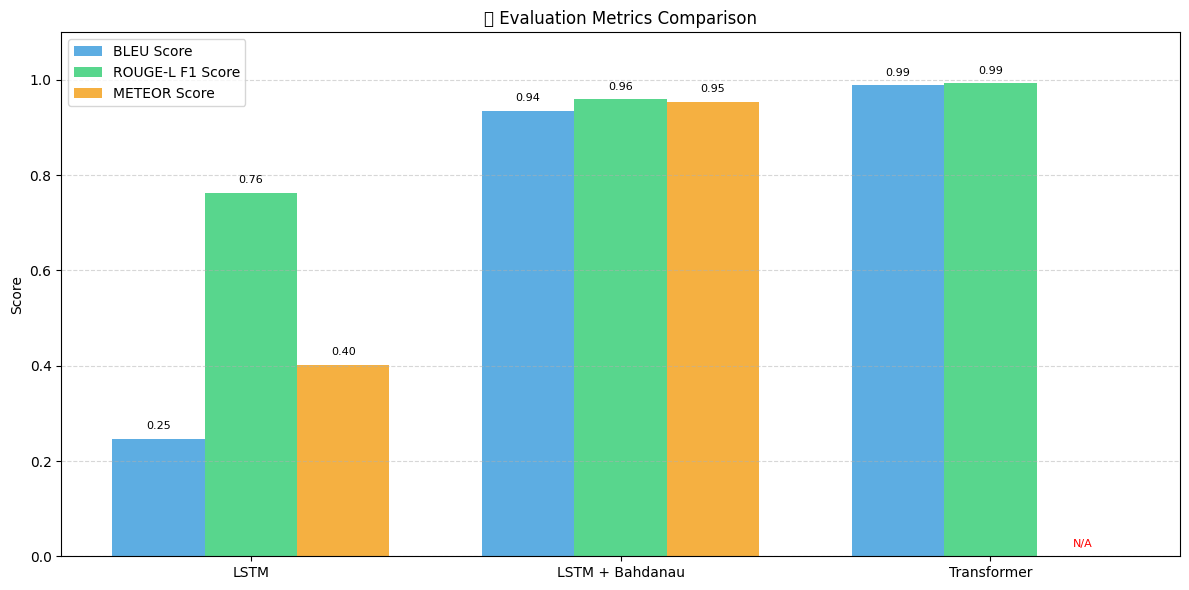

<ipython-input-129-17939cc2aa01>:60: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


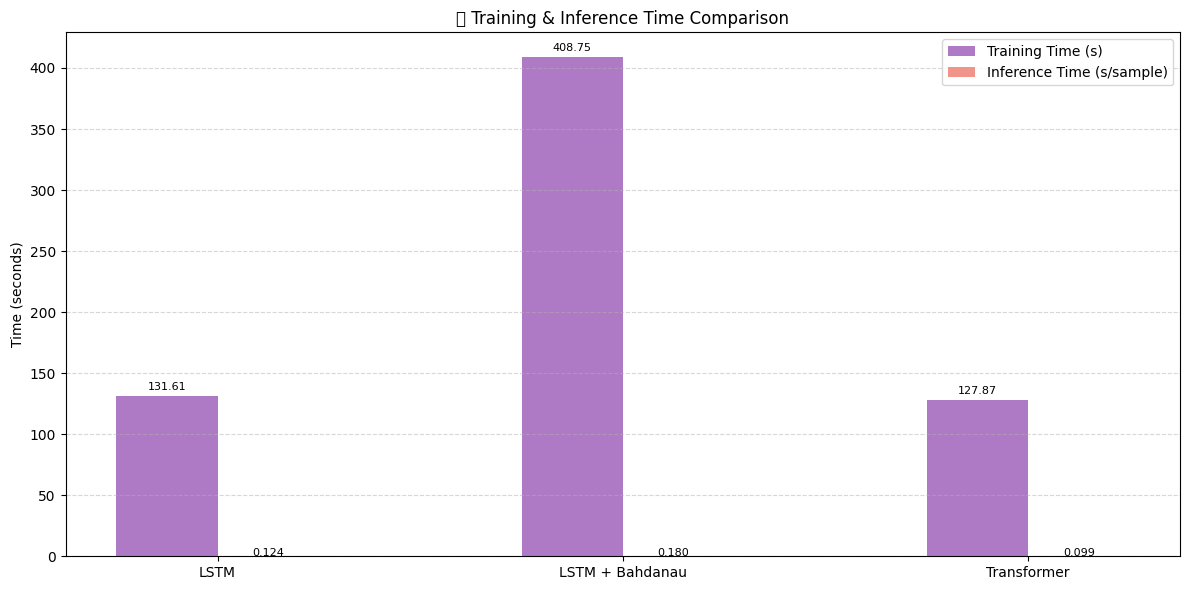

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['LSTM', 'LSTM + Bahdanau', 'Transformer']

# Evaluation Metrics
bleu_scores = [0.2470, 0.9352, 0.9886]
rouge_scores = [0.7627, 0.9596, 0.9933]
meteor_scores = [0.4017, 0.9537, 0.0]

# Timing Metrics
training_times = [131.61, 408.75, 127.87]
infer_speeds = [0.1240, 0.1798, 0.0993]

# Common setup
x = np.arange(len(models))
width = 0.25

# 🎯 Plot 1: Evaluation Metrics
plt.figure(figsize=(12, 6))
plt.bar(x - width, bleu_scores, width, label='BLEU Score', color='#5DADE2')
plt.bar(x, rouge_scores, width, label='ROUGE-L F1 Score', color='#58D68D')
plt.bar(x + width, meteor_scores, width, label='METEOR Score', color='#F5B041')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('📊 Evaluation Metrics Comparison')
plt.ylim(0, 1.1)
plt.legend()

# 📌 Labels on bars
for i, (b, r, m) in enumerate(zip(bleu_scores, rouge_scores, meteor_scores)):
    plt.text(x[i] - width, b + 0.02, f'{b:.2f}', ha='center', fontsize=8)
    plt.text(x[i], r + 0.02, f'{r:.2f}', ha='center', fontsize=8)
    if m > 0:
        plt.text(x[i] + width, m + 0.02, f'{m:.2f}', ha='center', fontsize=8)
    else:
        plt.text(x[i] + width, 0.02, 'N/A', ha='center', fontsize=8, color='red')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 🎯 Plot 2: Timing Metrics
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, training_times, width, label='Training Time (s)', color='#AF7AC5')
plt.bar(x + width/2, infer_speeds, width, label='Inference Time (s/sample)', color='#F1948A')

plt.xticks(x, models)
plt.ylabel('Time (seconds)')
plt.title('⏱️ Training & Inference Time Comparison')
plt.legend()

# 📌 Labels on bars
for i, (t, inf) in enumerate(zip(training_times, infer_speeds)):
    plt.text(x[i] - width/2, t + 5, f'{t:.2f}', ha='center', fontsize=8)
    plt.text(x[i] + width/2, inf + 0.005, f'{inf:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from tabulate import tabulate
from IPython.display import display, HTML

# Data
models = ['LSTM', 'LSTM + Bahdanau', 'Transformer']
bleu_scores = [0.2470, 0.9352, 0.9886]
rouge_scores = [0.7627, 0.9596, 0.9933]
meteor_scores = [0.4017, 0.9537, 'N/A']
training_times = [131.61, 408.75, 127.87]
infer_speeds = [0.1240, 0.1798, 0.0993]

# Table Data
table_data = [
    ["Model", "BLEU", "ROUGE-L", "METEOR", "Training Time (s)", "Inference Time (s/sample)"],
]

for i in range(len(models)):
    table_data.append([
        models[i],
        bleu_scores[i],
        rouge_scores[i],
        meteor_scores[i],
        training_times[i],
        infer_speeds[i]
    ])

# Display as HTML
html = """
<style>
    table {
        border-collapse: collapse;
        width: 80%;
        margin: 10px auto;
        font-family: Arial, sans-serif;
    }
    th, td {
        border: 1px solid #999;
        padding: 8px 12px;
        text-align: center;
    }
    th {
        background-color: #4CAF50;
        color: white;
    }
    tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    caption {
        caption-side: top;
        font-size: 20px;
        font-weight: bold;
        margin-bottom: 10px;
    }
</style>

<table>
    <caption>Model Performance Comparison</caption>
    <tr>
        <th>Model</th>
        <th>BLEU</th>
        <th>ROUGE-L</th>
        <th>METEOR</th>
        <th>Training Time (s)</th>
        <th>Inference Time (s/sample)</th>
    </tr>
"""

for i in range(len(models)):
    html += f"""
    <tr>
        <td>{models[i]}</td>
        <td>{bleu_scores[i]}</td>
        <td>{rouge_scores[i]}</td>
        <td>{meteor_scores[i]}</td>
        <td>{training_times[i]}</td>
        <td>{infer_speeds[i]}</td>
    </tr>
    """

html += "</table>"

# Show HTML in Colab
display(HTML(html))

# Also print grid version
print("\nText Version:")
print(tabulate(table_data, headers="firstrow", tablefmt="grid", stralign="center", numalign="center"))


Model,BLEU,ROUGE-L,METEOR,Training Time (s),Inference Time (s/sample)
LSTM,0.247,0.7627,0.4017,131.61,0.124
LSTM + Bahdanau,0.9352,0.9596,0.9537,408.75,0.1798
Transformer,0.9886,0.9933,N/A,127.87,0.0993



Text Version:
+-----------------+--------+-----------+----------+---------------------+-----------------------------+
|      Model      |  BLEU  |  ROUGE-L  |  METEOR  |  Training Time (s)  |  Inference Time (s/sample)  |
+=================+========+===========+==========+=====================+=============================+
|      LSTM       | 0.247  |  0.7627   |  0.4017  |       131.61        |            0.124            |
+-----------------+--------+-----------+----------+---------------------+-----------------------------+
| LSTM + Bahdanau | 0.9352 |  0.9596   |  0.9537  |       408.75        |           0.1798            |
+-----------------+--------+-----------+----------+---------------------+-----------------------------+
|   Transformer   | 0.9886 |  0.9933   |   N/A    |       127.87        |           0.0993            |
+-----------------+--------+-----------+----------+---------------------+-----------------------------+
